In [1]:
import uproot
import awkward as ak
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
with uproot.open("/home/lvaughan/Pileup/Pileup_Project/pythia/output/dataset_diHiggs_mu200_NumEvents20k_MinJetpT80.root:fastjet") as f:
    jet_label = f["jet_true_Efrac"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_m = f["jet_m"].array()

In [3]:
threshold=0.3

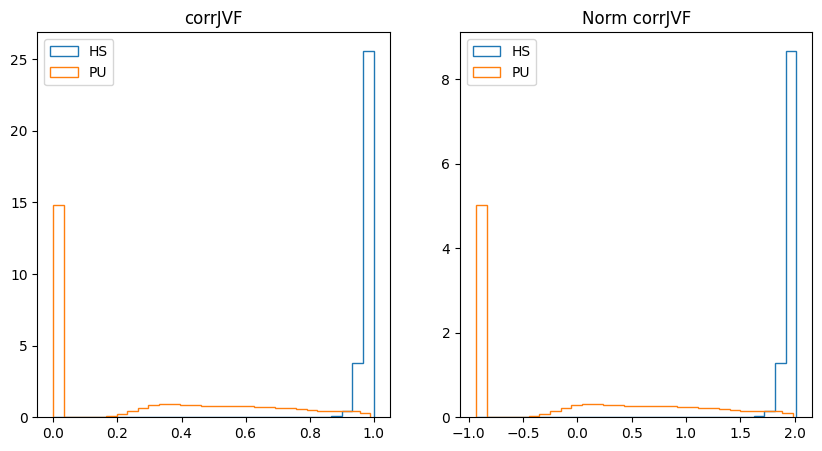

Mean Before:  0.3157989564894604 		 Mean After:  -5.644999110004424e-05
STD Before:  0.339043508915272 		 STD After:  1.000094557275535


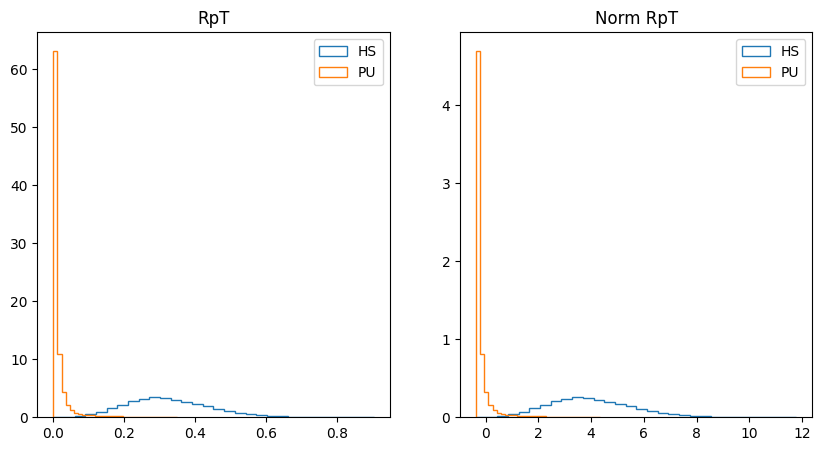

Mean Before:  0.0266385186873751 		 Mean After:  7.02141409062082e-05
STD Before:  0.07430499401179541 		 STD After:  1.0011916465287343


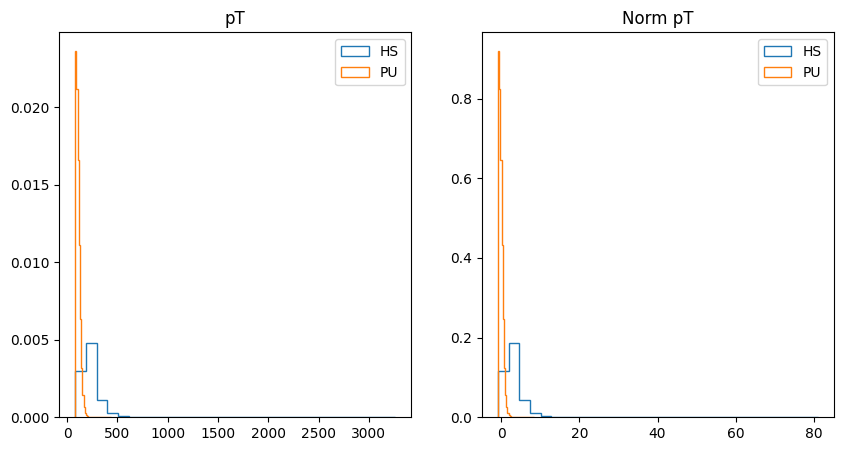

Mean Before:  111.53518662531903 		 Mean After:  0.0021381010142634757
STD Before:  38.88803654948659 		 STD After:  0.9954125423706196


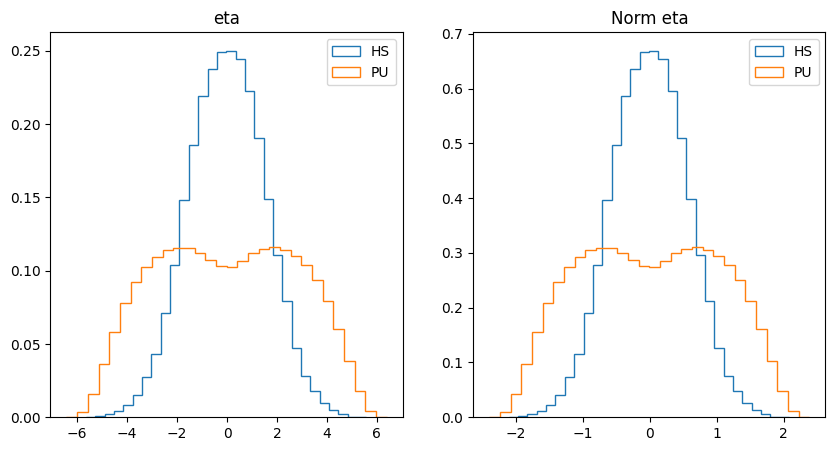

Mean Before:  0.00295708764556512 		 Mean After:  -1.2891362066383554e-08
STD Before:  2.676803636604782 		 STD After:  1.0003870972105264


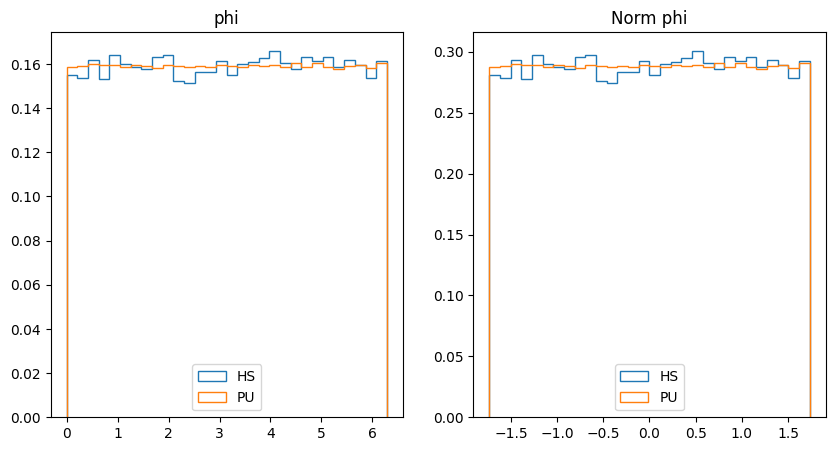

Mean Before:  3.1412680481836257 		 Mean After:  0.0003137501880053172
STD Before:  1.8121308690997684 		 STD After:  1.0010009739794874


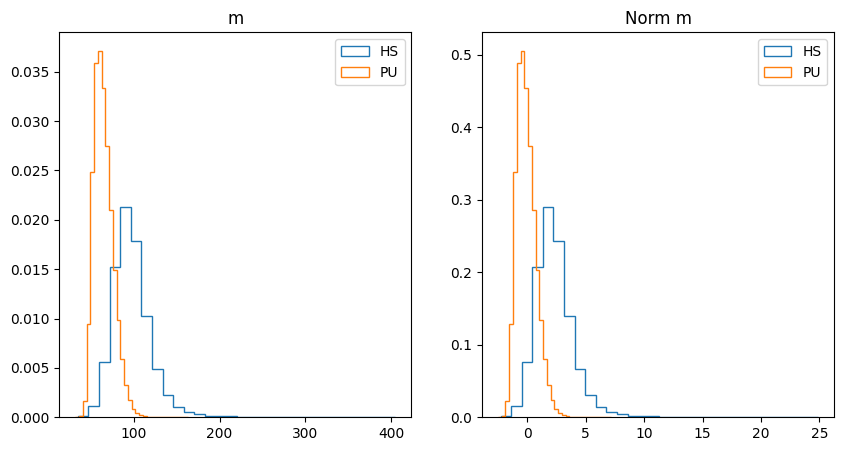

Mean Before:  66.11676111356516 		 Mean After:  7.817743499841612e-06
STD Before:  13.613271096617792 		 STD After:  1.0003492590455174


In [4]:
num_feats = 6
mean_list = []
std_list = []
feat_list = [jet_corrJVF,jet_RpT,jet_pt,jet_eta,jet_phi,jet_m]
norm_list = []
for feat in feat_list:
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm_list.append(((feat-mean)/std))    
    
feat_names = ["corrJVF","RpT","pT","eta","phi","m"]

plot=True
if plot:
    for i in range(num_feats):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

        ax1.set_title(feat_names[i])
        ax1.hist(ak.ravel(feat_list[i][jet_label>threshold]),histtype='step',label='HS',density=True,bins=30)
        ax1.hist(ak.ravel(feat_list[i][jet_label<threshold]),histtype='step',label='PU',density=True,bins=30)
        ax1.legend()

        ax2.set_title("Norm "+feat_names[i])
        ax2.hist(ak.ravel(norm_list[i][jet_label>threshold]),histtype='step',label='HS',density=True,bins=30)
        ax2.hist(ak.ravel(norm_list[i][jet_label<threshold]),histtype='step',label='PU',density=True,bins=30)
        ax2.legend()

        plt.show()

        print("Mean Before: ", ak.mean(feat_list[i]), "\t\t Mean After: ", ak.mean(norm_list[i]))
        print("STD Before: ", ak.std(feat_list[i]), "\t\t STD After: ", ak.std(norm_list[i]))

In [5]:
num_events = len(jet_pt)
train_split = int(0.7*num_events)
test_split = int(0.75*num_events)

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
jet_feats = ak.concatenate(Norm_list, axis=2)

X_train = jet_feats[0:train_split]
X_train = torch.nested.nested_tensor(ak.to_list(X_train), dtype=torch.float32)    
y_train = jet_label[0:train_split]
y_train = torch.nested.nested_tensor(ak.to_list(y_train), dtype=torch.float32)
    
X_val = jet_feats[train_split:test_split]
X_val = torch.nested.nested_tensor(ak.to_list(X_val), dtype=torch.float32)
y_val = jet_label[train_split:test_split]
y_val = torch.nested.nested_tensor(ak.to_list(y_val), dtype=torch.float32)

X_test = jet_feats[test_split:]
X_test = torch.nested.nested_tensor(ak.to_list(X_test), dtype=torch.float32)
y_test = jet_label[test_split:]
y_test = torch.nested.nested_tensor(ak.to_list(y_test), dtype=torch.float32)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:226: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [6]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        context, weights = self.attention(Query, Key, Value)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class AttnModel(nn.Module):
    def __init__(self, in_feats, embed_dim, num_heads, out_classes):
        super(AttnModel, self).__init__()        
        self.preprocess = nn.Linear(in_feats,embed_dim)

        self.encoder1 = Encoder(embed_dim, num_heads)
        self.encoder2 = Encoder(embed_dim, num_heads)
        self.encoder3 = Encoder(embed_dim, num_heads)
        self.encoder4 = Encoder(embed_dim, num_heads)
        
        self.classifier = nn.Linear(embed_dim,out_classes)
    def forward(self, jet_feats,return_weights=False):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.preprocess(jet_feats))
        
        # Attention Encoder
        jet_embedding, jet_weights = self.encoder1(jet_embedding,jet_embedding,jet_embedding)
        #jet_embedding, jet_weights = self.encoder2(jet_embedding,jet_embedding,jet_embedding)
        #jet_embedding, jet_weights = self.encoder3(jet_embedding,jet_embedding,jet_embedding)
        #jet_embedding, jet_weights = self.encoder4(jet_embedding,jet_embedding,jet_embedding)

        # Classify
        output = F.sigmoid(self.classifier(jet_embedding))
        
        if return_weights:
            return output, jet_weights
        return output

In [7]:
class BaselineNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(BaselineNN, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))

        # Classify
        output = F.sigmoid(self.jet_classifier(jet_embedding))
        return output

In [8]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'val_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        num_train = X_train.size(0)
        model.train()
        for i in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[i].to(device))
            loss = loss_fn(output, y_train[i].reshape(-1,1).to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].reshape(-1,1).to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['val_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),6),'\tVal Loss:',round(float(np.mean(cum_loss_val)),6))

    return history

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [10]:
hidden_layer = 32
num_heads=8

model = AttnModel(6,hidden_layer,num_heads,1)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Attention Model Trainable Params: ", params)

fudge_factor = 1
baseline = BaselineNN(6,int(params/num_heads*fudge_factor),1)
print("Baseline Model Trainable Params: ", sum(p.numel() for p in baseline.parameters() if p.requires_grad))

Attention Model Trainable Params:  21377
Baseline Model Trainable Params:  21377


In [11]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.MSELoss()

Epochs = 40

# Train baseline NN
print("Training BaselineNN")
baseline.to(device)
optimizer = optim.AdamW(baseline.parameters(), lr=0.0001)
data = [X_train, y_train, X_val, y_val]
baseline_history = train(baseline, data, epochs=Epochs)
print()


Epochs = 80

# Train Attention Model
print("Training AttnJVT")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
data = [X_train, y_train, X_val, y_val]
model_history = train(model, data, epochs=Epochs)
print()

Training BaselineNN
Epoch: 1 	Train Loss: 0.001076 	Val Loss: 0.000396
Epoch: 2 	Train Loss: 0.000425 	Val Loss: 0.00039
Epoch: 3 	Train Loss: 0.000415 	Val Loss: 0.000388
Epoch: 4 	Train Loss: 0.00041 	Val Loss: 0.000387
Epoch: 5 	Train Loss: 0.000405 	Val Loss: 0.000386
Epoch: 6 	Train Loss: 0.000402 	Val Loss: 0.000385
Epoch: 7 	Train Loss: 0.000398 	Val Loss: 0.000385
Epoch: 8 	Train Loss: 0.000396 	Val Loss: 0.000384
Epoch: 9 	Train Loss: 0.000393 	Val Loss: 0.000384
Epoch: 10 	Train Loss: 0.000391 	Val Loss: 0.000384
Epoch: 11 	Train Loss: 0.000389 	Val Loss: 0.000383
Epoch: 12 	Train Loss: 0.000387 	Val Loss: 0.000382
Epoch: 13 	Train Loss: 0.000385 	Val Loss: 0.00038
Epoch: 14 	Train Loss: 0.000384 	Val Loss: 0.000379
Epoch: 15 	Train Loss: 0.000382 	Val Loss: 0.000377
Epoch: 16 	Train Loss: 0.000381 	Val Loss: 0.000376
Epoch: 17 	Train Loss: 0.00038 	Val Loss: 0.000375
Epoch: 18 	Train Loss: 0.000379 	Val Loss: 0.000374
Epoch: 19 	Train Loss: 0.000378 	Val Loss: 0.000373
Epoch

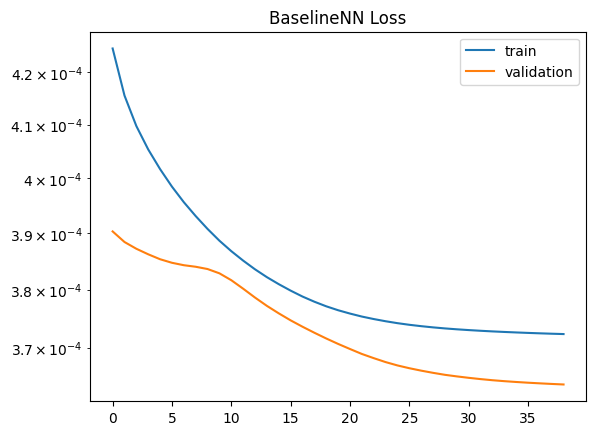

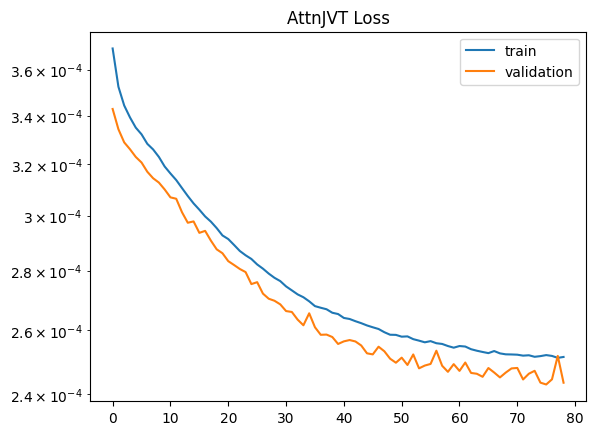

In [12]:
plt.plot(baseline_history['train_loss'][1:],label='train')
plt.plot(baseline_history['val_loss'][1:],label='validation')
plt.title("BaselineNN Loss")
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(model_history['train_loss'][1:],label='train')
plt.plot(model_history['val_loss'][1:],label='validation')
plt.title("AttnJVT Loss")
plt.legend()
plt.yscale('log')
plt.show()

In [16]:
def roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    fake_rate = []
    
    thresholds = np.linspace(0,0.9,1000)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        fake_rate.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    return np.array(sig_eff), np.array(fake_rate), thresholds

y_pred_baseline = []
y_pred_attn = []
weights = []
y_Test = []
for event in range(X_test.size(0)):
    y_pred_baseline.append(baseline(X_test[event].to(device)).detach().cpu().numpy())
    output, weight =model(X_test[event].to(device),return_weights=True)
    y_pred_attn.append(output.detach().cpu().numpy())
    weights.append(weight.detach().cpu().numpy())
    y_Test.append(y_test[event].detach().numpy())

/tmp/ipykernel_23130/71446761.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred_baseline = np.array(ak.ravel(y_pred_baseline))
/tmp/ipykernel_23130/71446761.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_pred_attn = np.array(ak.ravel(y_pred_attn))
/tmp/ipykernel_23130/71446761.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_Test = np.array(ak.ravel(ak.Array(y_Test)>threshold)).astype(int)


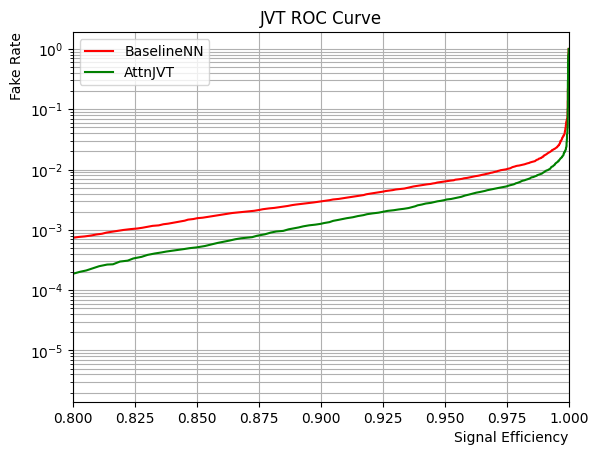

In [17]:
y_pred_baseline = np.array(ak.ravel(y_pred_baseline))
y_pred_attn = np.array(ak.ravel(y_pred_attn))
y_Test = np.array(ak.ravel(ak.Array(y_Test)>threshold)).astype(int)

x1,y1,th1 = roc(y_Test,y_pred_baseline)
x2,y2,th2 = roc(y_Test,y_pred_attn)

plt.title("JVT ROC Curve")
plt.plot(x1,y1,color='r',label='BaselineNN')
plt.plot(x2,y2,color='g',label='AttnJVT')

plt.ylabel('Fake Rate',loc='top')
plt.xlabel('Signal Efficiency',loc='right')
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlim([0.8, 1])
plt.grid(which='both')
plt.show()

In [18]:
with open('Baseline_MSE_mu200.pkl', 'wb') as f:
    pickle.dump([x1,y1], f)
with open('AttnJVT_MSE_mu200.pkl', 'wb') as f:
    pickle.dump([x2,y2], f)